In [ ]:
from IPython.core.display import display, HTML

def highlight_corrected_tokens(response, corrected_tokens, tokenizer):
    """
    使用 HTML 高亮被 target model 修正的 token（红色背景）。
    这里保证 token 级别的一一对应。
    """
    # **使用 tokenizer 进行 token 级别拆分**
    token_ids = tokenizer(response, return_tensors="pt").input_ids[0].tolist()
    tokens = [tokenizer.decode([tid]) for tid in token_ids]  # 确保 token 与 token_id 对应

    highlighted_text = []
    
    for i, token in enumerate(tokens):
        # 检查该位置是否在 corrected_tokens 中
        correction = next((c for c in corrected_tokens if c["position"] == i), None)
        if correction:
            highlighted_text.append(f'<span style="background-color: red; color: white;">{correction["target"]}</span>')
        else:
            highlighted_text.append(token)

    return " ".join(highlighted_text)

def display_results(results, tokenizer):
    """
    在 Notebook 中展示问题、生成的答案，并高亮被修正的 token。
    """
    for item in results:
        question = item["question"]
        generated_answer = item["generated_answer"]
        corrected_tokens = item["corrected_tokens"]

        highlighted_answer = highlight_corrected_tokens(generated_answer, corrected_tokens, tokenizer)

        html_content = f"""
        <div style="border: 1px solid #ccc; padding: 10px; margin-bottom: 10px;">
            <p><b>Question:</b> {question}</p>
            <p><b>Generated Answer:</b> {highlighted_answer}</p>
        </div>
        """
        display(HTML(html_content))

# **加载 JSON 结果**
import json
from transformers import AutoTokenizer

with open("math500_results.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# **加载 tokenizer，确保和生成时一致**
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

# **显示结果**
display_results(results, tokenizer)

In [1]:
import __init__
from utils.data_utils import read_saved_results
from utils.qwen_math_parser import *

/home/wxy320/miniconda3/envs/multio1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def check_math_correctness(ref, generation):
    if not find_box(generation): return False
    answer = strip_answer_string(ref)
    pred = extract_answer(generation)
    pred = strip_answer_string(pred)
    return math_equal(pred, answer)


In [3]:
deepseek_32b_path = '/home/wxy320/ondemand/program/speculative_thinking/results/MATH500_deepseek-32b_None_0.01.json'
deepseek_1b_path = '/home/wxy320/ondemand/program/speculative_thinking/results/MATH500_deepseek-1.5b_None_0.01.json'

results_32b = read_saved_results(deepseek_32b_path)
results_1b = read_saved_results(deepseek_1b_path)

## 统计词汇

In [18]:
import re
from collections import Counter
from transformers import AutoTokenizer
import json

# 目标关键词
keywords = {"wait", "hmm", "alternatively"}

# 存储关键词前 3 个单词
collected_words = {keyword: Counter() for keyword in keywords}

# 遍历所有结果
for result in results_32b:
    text = result['generated_answer'].lower()  # 直接处理原始文本
    
    # 以关键词进行分割
    for keyword in keywords:
        parts = re.split(rf'\b{keyword}\b', text, flags=re.IGNORECASE)  # \b 确保匹配完整单词
        # 遍历找到的分割点
        for i in range(1, len(parts)):  # 从1开始，因为0是文本开头
            before_keyword = parts[i - 1]  # 关键词前的文本
            token_ids = tokenizer.encode(before_keyword)
            decoded_tokens = [tokenizer.decode([t]) for t in token_ids]
            
            # 取最后 3 个 token 进行统计
            for token in decoded_tokens[-2:]:
                collected_words[keyword][token] += 1  # 统计出现次数

# # **转换 Counter 为普通字典**，方便 JSON 序列化
# collected_words_dict = {keyword: dict(counts) for keyword, counts in collected_words.items()}

# # **写入 JSON 文件**
# output_file = "collected_tokens_1b.json"
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(collected_words_dict, f, indent=4, ensure_ascii=False)  # `ensure_ascii=False` 处理非 ASCII 字符

# print(f"统计结果已保存至 {output_file}")

In [49]:
print('wait : ',collected_words['\n\n'])
print('hmm: ',collected_words['hmm'])
print('alternatively: ', collected_words['alternatively'])

wait :  Counter({'<｜begin▁of▁sentence｜>': 4103})
hmm:  Counter({'<｜begin▁of▁sentence｜>': 1195})
alternatively:  Counter({'<｜begin▁of▁sentence｜>': 1763})


In [64]:
# 存储 `\n\n` 后 3 个 token 的统计
collected_tokens = Counter()

# 遍历所有结果
for result in results_1b:
    text = result['generated_answer'].strip()  # 处理原始文本

    # 按 `\n\n` 进行分割
    sections = re.split(r'\n\n+', text)  # `\n\n+` 允许匹配多个连续的 `\n\n`

    # 遍历每个段落，取其后三个 token
    for i in range(1, len(sections)):  # 从 1 开始，确保有前一段落
        after_break = sections[i].strip()  # `\n\n` 后的文本
        token_ids = tokenizer.encode(after_break, add_special_tokens=False)  # 仅编码文本部分
        decoded_tokens = [tokenizer.decode([t]).lower() for t in token_ids]

        # 取 `\n\n` 后的 3 个 token 并统计
        for token in decoded_tokens[:1]:  # 取前 3 个 token
            collected_tokens[token] += 1  # 统计出现次数

In [65]:
filtered_sorted_tokens = dict(sorted(
    {k: t for k, t in collected_tokens.items() if t > 100}.items(), 
    key=lambda item: item[1],  # 依据 t 进行排序
    reverse=True  # 倒序排序
))
filtered_sorted_tokens

# **写入 JSON 文件**
output_file = "collected_tokens_nn_1b.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(filtered_sorted_tokens, f, indent=4, ensure_ascii=False)  # `ensure_ascii=False` 处理非 ASCII 字符

### 统计thoughts数量

In [5]:
text = 'This is a test.\n\nWait,Here comes the next part.\n\nThis should not be split.'.strip()  # 处理原始文本

keywords = {"wait", "hmm", "alternately", 'yes', 'yeah'}

# **按 `\n\n` 进行初步分割**
sections = re.split(r'\n\n+', text)

# **存储最终分割的部分**
filtered_sections = []
temp_section = ""

for section in sections:
    last_20_chars = section[:20].lower()  # 取后 20 个字符并转换为小写
    # print(last_20_chars)
    if any(keyword in last_20_chars for keyword in keywords):
        # 如果当前 `temp_section` 不是空的，则合并存储
        if temp_section:
            filtered_sections.append(temp_section.strip())
        temp_section = section+ "\n\n"
    else:
        # 累积无关键词的部分，等待下次匹配
        temp_section += section + "\n\n"

# **如果最后 `temp_section` 仍有内容，加入最终结果**
if temp_section:
    filtered_sections.append(temp_section.strip())
filtered_sections

['This is a test.',
 'Wait,Here comes the next part.\n\nThis should not be split.']

In [6]:
import re
import math

# 目标关键词
keywords = {"wait", "hmm", "alternatively", 'yes', 'yeah', '**final', 'double-check'}

def segement(results_1b):
    filtered_sections_all = []
    for result in results_1b:
        text = result['generated_answer'].strip()  # 处理原始文本

        # **按 `\n\n` 进行初步分割**
        sections = re.split(r'\n\n+', text)

        # **存储最终分割的部分**
        filtered_sections = []
        temp_section = ""

        for section in sections:
            last_20_chars = section[:30].lower()  # 取后 20 个字符并转换为小写
            # print(last_20_chars)
            if any(keyword in last_20_chars for keyword in keywords):
                # 如果当前 `temp_section` 不是空的，则合并存储
                if temp_section:
                    filtered_sections.append(temp_section.strip())
                temp_section = section+ "\n\n"
            else:
                # 累积无关键词的部分，等待下次匹配
                temp_section += section + "\n\n"

        # **如果最后 `temp_section` 仍有内容，加入最终结果**
        if temp_section:
            filtered_sections.append(temp_section.strip())
        # print(filtered_sections)
        filtered_sections_all.append({
            'right': check_math_correctness(result['answer'], result['generated_answer']), 
            'question': result['question'],
            'filtered_sections':filtered_sections,
            'num_tokens': result['num_tokens']
        })
        # break

    return filtered_sections_all

def avg_l(s):
    return sum(s)/len(s) if len(s)>0 else 0

def avg(s):
    if len(s) == 0:
        return 0, 0  # 避免除零错误
    
    mean = sum(s) / len(s)  # 计算均值
    variance = sum((x - mean) ** 2 for x in s) / len(s)  # 计算方差（无偏估计可用 n-1）
    std_dev = math.sqrt(variance)  # 计算标准差
    
    return mean, std_dev

In [7]:
filtered_sections_all_1b = segement(results_1b)
filtered_sections_all_32b = segement(results_32b)
filtered_sections_all_1b[0], len(filtered_sections_all_1b), filtered_sections_all_32b[0], len(filtered_sections_all_32b)

({'right': True,
  'question': 'Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\\theta),$ where $r > 0$ and $0 \\le \\theta < 2 \\pi.$',
  'filtered_sections': ['Okay, so I need to convert the rectangular coordinates (0, 3) to polar coordinates. Hmm, I remember that polar coordinates are represented as (r, θ), where r is the distance from the origin to the point, and θ is the angle made with the positive x-axis. \n\nFirst, I should recall the formulas for converting from rectangular (x, y) to polar (r, θ). I think the formulas are:\n- r = √(x² + y²)\n- θ = arctan(y/x)\n\nLet me write that down to keep track:\nr = √(x² + y²)\nθ = arctan(y/x)\n\nAlright, so given the point (0, 3), x is 0 and y is 3. Let me plug these into the formulas.\n\nStarting with r:\nr = √(0² + 3²) = √(0 + 9) = √9 = 3\n\nSo, r is 3. That seems straightforward.\n\nNow, for θ:\nθ = arctan(y/x) = arctan(3/0)',
   "Wait, dividing by zero is undefined. Hmm, 

In [8]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

avg_s, avg_s_l,num_tokens = {'right': [[], []], 'wrong': [[], []]}, {'right': [[], []], 'wrong': [[], []]},{'right': [[], []], 'wrong': [[], []]}

for s_1 in filtered_sections_all_1b:
    key1 = 'right' if s_1['right'] else 'wrong'
    # 统计 filtered_sections 的数量
    avg_s[key1][0].append(len(s_1['filtered_sections']))
   
    # # **使用 tokenizer 计算 token 个数**
    token_count_1b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_1['filtered_sections']]
   
    # 统计 filtered_sections 的 token 数量
    avg_s_l[key1][0].append(avg_l(token_count_1b)) # s_1['num_tokens']/avg_s[key1][0][-1]
    num_tokens[key1][0].append(s_1['num_tokens'])
   
for s_32 in filtered_sections_all_32b:
    key32 = 'right' if s_32['right'] else 'wrong'

    # 统计 filtered_sections 的数量
    avg_s[key32][1].append(len(s_32['filtered_sections']))

    # # **使用 tokenizer 计算 token 个数**
    token_count_32b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_32['filtered_sections']]

    # 统计 filtered_sections 的 token 数量
    avg_s_l[key32][1].append(avg_l(token_count_32b)) # s_32['num_tokens']/avg_s[key32][1][-1]
    num_tokens[key32][1].append(s_32['num_tokens'])

Token indices sequence length is longer than the specified maximum sequence length for this model (19905 > 16384). Running this sequence through the model will result in indexing errors


In [9]:
print('num of thoughts')
print(f'right: 1.5b: {avg_s['right'][0]}, 32b: {avg_s['right'][1]}')
print(f'wrong: 1.5b: {avg_s['wrong'][0]}, 32b: {avg_s['wrong'][1]}')
print('length of thoughts')
print(f'right: 1.5b: {avg_s_l['right'][0]}, 32b: {avg_s_l['right'][1]}')
print(f'wrong: 1.5b: {avg_s_l['wrong'][1]}, 32b: {avg_s_l['wrong'][1]}')
print('avg num of tokens')
print(f'right: 1.5b: {num_tokens['right'][0]}, 32b: {num_tokens['right'][1]}')
print(f'wrong: 1.5b: {num_tokens['wrong'][0]}, 32b: {num_tokens['wrong'][1]}')

num of thoughts
right: 1.5b: [5, 12, 10, 5, 24, 7, 9, 20, 6, 15, 13, 14, 8, 17, 21, 17, 7, 21, 9, 7, 20, 11, 10, 9, 39, 4, 70, 15, 6, 10, 7, 7, 10, 4, 3, 4, 3, 14, 8, 7, 11, 28, 8, 4, 2, 3, 3, 5, 29, 8, 3, 10, 15, 13, 6, 6, 38, 12, 5, 5, 37, 5, 3, 4, 22, 10, 12, 9, 6, 12, 36, 5, 5, 8, 3, 41, 5, 6, 4, 48, 6, 115, 6, 20, 11, 10, 76, 8, 5, 7, 7, 17, 3, 29, 4, 3, 8, 6, 5, 60, 3, 10, 22, 8, 6, 44, 11, 62, 16, 6, 4, 4, 3, 9, 40, 80, 71, 5, 18, 9, 10, 31, 10, 72, 22, 7, 23, 59, 132, 10, 15, 9, 9, 17, 16, 69, 64, 65, 5, 123, 5, 4, 30, 1, 12, 23, 3, 14, 51, 145, 4, 5, 13, 7, 6, 17, 46, 8, 4, 7, 23, 25, 11, 5, 4, 47, 18, 4, 19, 7, 6, 21, 4, 7, 2, 22, 13, 15, 9, 16, 4, 6, 22, 5, 16, 130, 32, 42, 4, 8, 15, 7, 5, 104, 7, 12, 9, 8, 1, 16, 48, 6, 4, 7, 4, 4, 36, 6, 3, 10, 7, 10, 5, 5, 14, 5, 10, 4, 4, 17, 11, 14, 14, 13, 13, 7, 20, 10, 8, 3, 4, 9, 5, 25, 55, 58, 12, 16, 8, 9, 8, 6, 69, 35, 7, 15, 8, 18, 8, 6, 13, 186, 27, 21, 4, 5, 30, 7, 5, 103, 5, 23, 4, 4, 20, 17, 17, 4, 10, 16, 113, 80, 4, 11, 13

In [10]:

print('avg num of thoughts')
print(f'right: 1.5b: {avg(avg_s['right'][0])}, 32b: {avg(avg_s['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s['wrong'][0])}, 32b: {avg(avg_s['wrong'][1])}')
print('avg length of thoughts')
print(f'right: 1.5b: {avg(avg_s_l['right'][0])}, 32b: {avg(avg_s_l['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s_l['wrong'][0])}, 32b: {avg(avg_s_l['wrong'][1])}')
print('avg num of tokens')
print(f'right: 1.5b: {avg(num_tokens['right'][0])}, 32b: {avg(num_tokens['right'][1])}')
print(f'wrong: 1.5b: {avg(num_tokens['wrong'][0])}, 32b: {avg(num_tokens['wrong'][1])}')

avg num of thoughts
right: 1.5b: (18.90487804878049, 25.998747166996733), 32b: (13.98279569892473, 23.663313212313856)
wrong: 1.5b: (138.3111111111111, 218.5495440623854), 32b: (138.11428571428573, 323.6392852216423)
avg length of thoughts
right: 1.5b: (255.4635688690364, 129.06428101599127), 32b: (295.160009790653, 128.87618247746545)
wrong: 1.5b: (206.0119628321458, 148.19062182765992), 32b: (233.4757125271959, 144.00071867183073)
avg num of tokens
right: 1.5b: (3412.765853658537, 3329.6445732540105), 32b: (2964.404301075269, 2464.4364297158354)
wrong: 1.5b: (13785.888888888889, 11578.366283187552), 32b: (11283.42857142857, 10064.738705814798)


##### 统计32b正确，1.5错误

In [11]:
l = min(len(results_32b), len(results_1b))
results_1b_2, results_32b_2 = [],[]
for i in range(l):
    r_32, r_1 = results_32b[i], results_1b[i]
    r_32_right_flag = check_math_correctness(r_32['answer'], r_32['generated_answer'])
    r_1_right_flag = check_math_correctness(r_1['answer'], r_1['generated_answer'])
    if r_32['question']==r_1['question'] and (r_32_right_flag and not r_1_right_flag):
        results_1b_2.append(r_1)
        results_32b_2.append(r_32)
len(results_1b_2), len(results_32b_2) 

(59, 59)

In [12]:
filtered_sections_all_1b = segement(results_1b_2)
filtered_sections_all_32b = segement(results_32b_2)

In [13]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

avg_s, avg_s_l,num_tokens = {'right': [[], []], 'wrong': [[], []]}, {'right': [[], []], 'wrong': [[], []]},{'right': [[], []], 'wrong': [[], []]}

for s_1 in filtered_sections_all_1b:
    key1 = 'right' if s_1['right'] else 'wrong'
    # 统计 filtered_sections 的数量
    avg_s[key1][0].append(len(s_1['filtered_sections']))
   
    # # **使用 tokenizer 计算 token 个数**
    token_count_1b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_1['filtered_sections']]
   
    # 统计 filtered_sections 的 token 数量
    avg_s_l[key1][0].append(avg_l(token_count_1b)) # s_1['num_tokens']/avg_s[key1][0][-1]
    num_tokens[key1][0].append(s_1['num_tokens'])
   
for s_32 in filtered_sections_all_32b:
    key32 = 'right' if s_32['right'] else 'wrong'

    # 统计 filtered_sections 的数量
    avg_s[key32][1].append(len(s_32['filtered_sections']))

    # # **使用 tokenizer 计算 token 个数**
    token_count_32b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_32['filtered_sections']]

    # 统计 filtered_sections 的 token 数量
    avg_s_l[key32][1].append(avg_l(token_count_32b)) # s_32['num_tokens']/avg_s[key32][1][-1]
    num_tokens[key32][1].append(s_32['num_tokens'])

In [14]:
print('1.5b wrong, 32b right')
print('num of thoughts')
print(f'right: 1.5b: {avg_s['right'][0]}, 32b: {avg_s['right'][1]}')
print(f'wrong: 1.5b: {avg_s['wrong'][0]}, 32b: {avg_s['wrong'][1]}')
print('length of thoughts')
print(f'right: 1.5b: {avg_s_l['right'][0]}, 32b: {avg_s_l['right'][1]}')
print(f'wrong: 1.5b: {avg_s_l['wrong'][1]}, 32b: {avg_s_l['wrong'][1]}')
print('avg num of tokens')
print(f'right: 1.5b: {num_tokens['right'][0]}, 32b: {num_tokens['right'][1]}')
print(f'wrong: 1.5b: {num_tokens['wrong'][0]}, 32b: {num_tokens['wrong'][1]}')

1.5b wrong, 32b right
num of thoughts
right: 1.5b: [], 32b: [75, 17, 4, 21, 41, 40, 30, 7, 4, 34, 38, 171, 22, 96, 88, 25, 52, 15, 10, 15, 44, 16, 7, 48, 7, 7, 18, 33, 32, 30, 7, 16, 21, 7, 8, 8, 41, 6, 16, 26, 40, 16, 9, 49, 16, 120, 13, 9, 45, 10, 16, 23, 9, 17, 31, 46, 98, 6, 15]
wrong: 1.5b: [318, 7, 2, 26, 390, 159, 169, 29, 35, 75, 125, 699, 121, 107, 142, 380, 57, 108, 27, 213, 620, 5, 2, 43, 133, 2, 31, 72, 432, 74, 29, 25, 178, 114, 31, 86, 172, 1336, 14, 20, 151, 43, 133, 98, 121, 189, 1, 1244, 234, 18, 26, 54, 171, 332, 163, 15, 181, 1, 38], 32b: []
length of thoughts
right: 1.5b: [], 32b: [124.6, 299.94117647058823, 174.25, 154.0952380952381, 107.0, 138.225, 293.93333333333334, 395.7142857142857, 633.0, 227.8235294117647, 96.26315789473684, 98.84795321637426, 292.54545454545456, 213.47916666666666, 68.19318181818181, 173.88, 131.0, 146.2, 291.6, 331.93333333333334, 123.4090909090909, 314.75, 226.71428571428572, 139.20833333333334, 337.2857142857143, 200.0, 274.2777777777777

In [15]:
print('1.5b wrong, 32b right')
print('avg num of thoughts')
print(f'right: 1.5b: {avg(avg_s['right'][0])}, 32b: {avg(avg_s['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s['wrong'][0])}, 32b: {avg(avg_s['wrong'][1])}')
print('avg length of thoughts')
print(f'right: 1.5b: {avg(avg_s_l['right'][0])}, 32b: {avg(avg_s_l['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s_l['wrong'][0])}, 32b: {avg(avg_s_l['wrong'][1])}')
print('avg num of tokens')
print(f'right: 1.5b: {avg(num_tokens['right'][0])}, 32b: {avg(num_tokens['right'][1])}')
print(f'wrong: 1.5b: {avg(num_tokens['wrong'][0])}, 32b: {avg(num_tokens['wrong'][1])}')

1.5b wrong, 32b right
avg num of thoughts
right: 1.5b: (0, 0), 32b: (30.35593220338983, 30.926793118679036)
wrong: 1.5b: (166.45762711864407, 254.364300476858), 32b: (0, 0)
avg length of thoughts
right: 1.5b: (0, 0), 32b: (232.14544287280705, 110.4314979477617)
wrong: 1.5b: (176.5181525129746, 129.39334715042693), 32b: (0, 0)
avg num of tokens
right: 1.5b: (0, 0), 32b: (5185.6949152542375, 3488.88192597055)
wrong: 1.5b: (14262.813559322034, 11184.377255455867), 32b: (0, 0)


#### 统计1.5b 正确，32b错误

In [16]:
l = min(len(results_32b), len(results_1b))
results_1b_2, results_32b_2 = [],[]
for i in range(l):
    r_32, r_1 = results_32b[i], results_1b[i]
    r_32_right_flag = check_math_correctness(r_32['answer'], r_32['generated_answer'])
    r_1_right_flag = check_math_correctness(r_1['answer'], r_1['generated_answer'])
    if r_32['question']==r_1['question'] and (not r_32_right_flag and r_1_right_flag):
        results_1b_2.append(r_1)
        results_32b_2.append(r_32)
len(results_1b_2), len(results_32b_2) 

(4, 4)

In [17]:
filtered_sections_all_1b = segement(results_1b_2)
filtered_sections_all_32b = segement(results_32b_2)

In [18]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

avg_s, avg_s_l,num_tokens = {'right': [[], []], 'wrong': [[], []]}, {'right': [[], []], 'wrong': [[], []]},{'right': [[], []], 'wrong': [[], []]}

for s_1 in filtered_sections_all_1b:
    key1 = 'right' if s_1['right'] else 'wrong'
    # 统计 filtered_sections 的数量
    avg_s[key1][0].append(len(s_1['filtered_sections']))
   
    # # **使用 tokenizer 计算 token 个数**
    token_count_1b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_1['filtered_sections']]
   
    # 统计 filtered_sections 的 token 数量
    avg_s_l[key1][0].append(avg_l(token_count_1b)) # s_1['num_tokens']/avg_s[key1][0][-1]
    num_tokens[key1][0].append(s_1['num_tokens'])
   
for s_32 in filtered_sections_all_32b:
    key32 = 'right' if s_32['right'] else 'wrong'

    # 统计 filtered_sections 的数量
    avg_s[key32][1].append(len(s_32['filtered_sections']))

    # # **使用 tokenizer 计算 token 个数**
    token_count_32b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_32['filtered_sections']]

    # 统计 filtered_sections 的 token 数量
    avg_s_l[key32][1].append(avg_l(token_count_32b)) # s_32['num_tokens']/avg_s[key32][1][-1]
    num_tokens[key32][1].append(s_32['num_tokens'])

In [19]:
print('1.5b right, 32b wrong')
print('num of thoughts')
print(f'right: 1.5b: {avg_s['right'][0]}, 32b: {avg_s['right'][1]}')
print(f'wrong: 1.5b: {avg_s['wrong'][0]}, 32b: {avg_s['wrong'][1]}')
print('length of thoughts')
print(f'right: 1.5b: {avg_s_l['right'][0]}, 32b: {avg_s_l['right'][1]}')
print(f'wrong: 1.5b: {avg_s_l['wrong'][1]}, 32b: {avg_s_l['wrong'][1]}')
print('avg num of tokens')
print(f'right: 1.5b: {num_tokens['right'][0]}, 32b: {num_tokens['right'][1]}')
print(f'wrong: 1.5b: {num_tokens['wrong'][0]}, 32b: {num_tokens['wrong'][1]}')

1.5b right, 32b wrong
num of thoughts
right: 1.5b: [70, 37, 115, 44], 32b: []
wrong: 1.5b: [], 32b: [96, 10, 55, 75]
length of thoughts
right: 1.5b: [95.81428571428572, 166.0, 126.0, 271.1363636363636], 32b: []
wrong: 1.5b: [78.67708333333333, 240.9, 130.72727272727272, 198.84], 32b: [78.67708333333333, 240.9, 130.72727272727272, 198.84]
avg num of tokens
right: 1.5b: [6708, 6146, 14494, 11931], 32b: []
wrong: 1.5b: [], 32b: [7554, 2412, 7193, 14922]


In [20]:
print('1.5b wrong, 32b right')
print('avg num of thoughts')
print(f'right: 1.5b: {avg(avg_s['right'][0])}, 32b: {avg(avg_s['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s['wrong'][0])}, 32b: {avg(avg_s['wrong'][1])}')
print('avg length of thoughts')
print(f'right: 1.5b: {avg(avg_s_l['right'][0])}, 32b: {avg(avg_s_l['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s_l['wrong'][0])}, 32b: {avg(avg_s_l['wrong'][1])}')
print('avg num of tokens')
print(f'right: 1.5b: {avg(num_tokens['right'][0])}, 32b: {avg(num_tokens['right'][1])}')
print(f'wrong: 1.5b: {avg(num_tokens['wrong'][0])}, 32b: {avg(num_tokens['wrong'][1])}')

1.5b wrong, 32b right
avg num of thoughts
right: 1.5b: (66.5, 30.581857366746057), 32b: (0, 0)
wrong: 1.5b: (0, 0), 32b: (59.0, 31.788362650504666)
avg length of thoughts
right: 1.5b: (164.73766233766233, 66.28219116583763), 32b: (0, 0)
wrong: 1.5b: (0, 0), 32b: (162.2860890151515, 62.25504020803516)
avg num of tokens
right: 1.5b: (9819.75, 3517.2935884711133), 32b: (0, 0)
wrong: 1.5b: (0, 0), 32b: (8020.25, 4471.810392615053)


#### 统计1.5b错误，32b错误

In [21]:
l = min(len(results_32b), len(results_1b))
results_1b_2, results_32b_2 = [],[]
for i in range(l):
    r_32, r_1 = results_32b[i], results_1b[i]
    r_32_right_flag = check_math_correctness(r_32['answer'], r_32['generated_answer'])
    r_1_right_flag = check_math_correctness(r_1['answer'], r_1['generated_answer'])
    if r_32['question']==r_1['question'] and (not r_32_right_flag and not r_1_right_flag):
        results_1b_2.append(r_1)
        results_32b_2.append(r_32)
len(results_1b_2), len(results_32b_2) 

(31, 31)

In [22]:
filtered_sections_all_1b = segement(results_1b_2)
filtered_sections_all_32b = segement(results_32b_2)

In [23]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

avg_s, avg_s_l,num_tokens = {'right': [[], []], 'wrong': [[], []]}, {'right': [[], []], 'wrong': [[], []]},{'right': [[], []], 'wrong': [[], []]}

for s_1 in filtered_sections_all_1b:
    key1 = 'right' if s_1['right'] else 'wrong'
    # 统计 filtered_sections 的数量
    avg_s[key1][0].append(len(s_1['filtered_sections']))
   
    # # **使用 tokenizer 计算 token 个数**
    token_count_1b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_1['filtered_sections']]
   
    # 统计 filtered_sections 的 token 数量
    avg_s_l[key1][0].append(avg_l(token_count_1b)) # s_1['num_tokens']/avg_s[key1][0][-1]
    num_tokens[key1][0].append(s_1['num_tokens'])
   
for s_32 in filtered_sections_all_32b:
    key32 = 'right' if s_32['right'] else 'wrong'

    # 统计 filtered_sections 的数量
    avg_s[key32][1].append(len(s_32['filtered_sections']))

    # # **使用 tokenizer 计算 token 个数**
    token_count_32b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_32['filtered_sections']]

    # 统计 filtered_sections 的 token 数量
    avg_s_l[key32][1].append(avg_l(token_count_32b)) # s_32['num_tokens']/avg_s[key32][1][-1]
    num_tokens[key32][1].append(s_32['num_tokens'])

Token indices sequence length is longer than the specified maximum sequence length for this model (19905 > 16384). Running this sequence through the model will result in indexing errors


In [24]:
print('num of thoughts')
print(f'right: 1.5b: {avg_s['right'][0]}, 32b: {avg_s['right'][1]}')
print(f'wrong: 1.5b: {avg_s['wrong'][0]}, 32b: {avg_s['wrong'][1]}')
print('length of thoughts')
print(f'right: 1.5b: {avg_s_l['right'][0]}, 32b: {avg_s_l['right'][1]}')
print(f'wrong: 1.5b: {avg_s_l['wrong'][1]}, 32b: {avg_s_l['wrong'][1]}')
print('avg num of tokens')
print(f'right: 1.5b: {num_tokens['right'][0]}, 32b: {num_tokens['right'][1]}')
print(f'wrong: 1.5b: {num_tokens['wrong'][0]}, 32b: {num_tokens['wrong'][1]}')

num of thoughts
right: 1.5b: [], 32b: []
wrong: 1.5b: [106, 13, 94, 8, 115, 13, 100, 6, 214, 7, 58, 17, 291, 9, 4, 23, 141, 4, 198, 119, 37, 11, 3, 2, 233, 86, 12, 131, 477, 3, 92], 32b: [107, 6, 86, 7, 103, 1357, 208, 9, 136, 5, 55, 139, 1507, 11, 10, 32, 101, 3, 30, 72, 64, 8, 3, 7, 107, 76, 5, 101, 196, 5, 42]
length of thoughts
right: 1.5b: [], 32b: []
wrong: 1.5b: [103.78504672897196, 450.3333333333333, 380.86046511627904, 185.57142857142858, 283.18446601941747, 24.146647015475313, 82.6826923076923, 173.0, 137.81617647058823, 478.0, 168.78181818181818, 94.56115107913669, 21.739880557398806, 419.3636363636364, 257.4, 219.4375, 131.7128712871287, 369.0, 155.9, 194.30555555555554, 112.78125, 370.25, 448.3333333333333, 286.7142857142857, 196.9626168224299, 235.77631578947367, 604.2, 241.36633663366337, 126.86734693877551, 487.6, 80.07142857142857], 32b: [103.78504672897196, 450.3333333333333, 380.86046511627904, 185.57142857142858, 283.18446601941747, 24.146647015475313, 82.6826923076

In [25]:
print('1.5b wrong, 32b wrong')
print('avg num of thoughts')
print(f'right: 1.5b: {avg(avg_s['right'][0])}, 32b: {avg(avg_s['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s['wrong'][0])}, 32b: {avg(avg_s['wrong'][1])}')
print('avg length of thoughts')
print(f'right: 1.5b: {avg(avg_s_l['right'][0])}, 32b: {avg(avg_s_l['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s_l['wrong'][0])}, 32b: {avg(avg_s_l['wrong'][1])}')
print('avg num of tokens')
print(f'right: 1.5b: {avg(num_tokens['right'][0])}, 32b: {avg(num_tokens['right'][1])}')
print(f'wrong: 1.5b: {avg(num_tokens['wrong'][0])}, 32b: {avg(num_tokens['wrong'][1])}')

1.5b wrong, 32b wrong
avg num of thoughts
right: 1.5b: (0, 0), 32b: (0, 0)
wrong: 1.5b: (84.74193548387096, 105.59813284698755), 32b: (148.32258064516128, 342.36722287124115)
avg length of thoughts
right: 1.5b: (0, 0), 32b: (0, 0)
wrong: 1.5b: (262.14534376218126, 164.5740269550573), 32b: (242.66147039971776, 148.90751747128553)
avg num of tokens
right: 1.5b: (0, 0), 32b: (0, 0)
wrong: 1.5b: (12878.193548387097, 12242.156584258622), 32b: (11704.483870967742, 10499.441118370394)


#### 统计1.5正确，32b正确

In [26]:
l = min(len(results_32b), len(results_1b))
results_1b_2, results_32b_2 = [],[]
for i in range(l):
    r_32, r_1 = results_32b[i], results_1b[i]
    r_32_right_flag = check_math_correctness(r_32['answer'], r_32['generated_answer'])
    r_1_right_flag = check_math_correctness(r_1['answer'], r_1['generated_answer'])
    if r_32['question']==r_1['question'] and (r_32_right_flag and r_1_right_flag):
        results_1b_2.append(r_1)
        results_32b_2.append(r_32)
len(results_1b_2), len(results_32b_2) 

(406, 406)

In [27]:
filtered_sections_all_1b = segement(results_1b_2)
filtered_sections_all_32b = segement(results_32b_2)

In [30]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

avg_s, avg_s_l,num_tokens = {'right': [[], []], 'wrong': [[], []]}, {'right': [[], []], 'wrong': [[], []]},{'right': [[], []], 'wrong': [[], []]}

for s_1 in filtered_sections_all_1b:
    key1 = 'right' if s_1['right'] else 'wrong'
    # 统计 filtered_sections 的数量
    avg_s[key1][0].append(len(s_1['filtered_sections']))
   
    # # **使用 tokenizer 计算 token 个数**
    token_count_1b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_1['filtered_sections']]
   
    # 统计 filtered_sections 的 token 数量
    avg_s_l[key1][0].append(avg_l(token_count_1b)) # s_1['num_tokens']/avg_s[key1][0][-1]
    num_tokens[key1][0].append(s_1['num_tokens'])
   
for s_32 in filtered_sections_all_32b:
    key32 = 'right' if s_32['right'] else 'wrong'

    # 统计 filtered_sections 的数量
    avg_s[key32][1].append(len(s_32['filtered_sections']))

    # # **使用 tokenizer 计算 token 个数**
    token_count_32b = [len(tokenizer.encode(ss, add_special_tokens=False)) for ss in s_32['filtered_sections']]

    # 统计 filtered_sections 的 token 数量
    avg_s_l[key32][1].append(avg_l(token_count_32b)) # s_32['num_tokens']/avg_s[key32][1][-1]
    num_tokens[key32][1].append(s_32['num_tokens'])

In [31]:
print('1.5b right, 32b right')
print('avg num of thoughts')
print(f'right: 1.5b: {avg(avg_s['right'][0])}, 32b: {avg(avg_s['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s['wrong'][0])}, 32b: {avg(avg_s['wrong'][1])}')
print('avg length of thoughts')
print(f'right: 1.5b: {avg(avg_s_l['right'][0])}, 32b: {avg(avg_s_l['right'][1])}')
print(f'wrong: 1.5b: {avg(avg_s_l['wrong'][0])}, 32b: {avg(avg_s_l['wrong'][1])}')
print('avg num of tokens')
print(f'right: 1.5b: {avg(num_tokens['right'][0])}, 32b: {avg(num_tokens['right'][1])}')
print(f'wrong: 1.5b: {avg(num_tokens['wrong'][0])}, 32b: {avg(num_tokens['wrong'][1])}')

1.5b right, 32b right
avg num of thoughts
right: 1.5b: (18.435960591133004, 25.511604380505204), 32b: (11.60344827586207, 21.39420961050354)
wrong: 1.5b: (0, 0), 32b: (0, 0)
avg length of thoughts
right: 1.5b: (256.357420164912, 129.21503140275453), 32b: (304.31729907181784, 128.80065452987168)
wrong: 1.5b: (0, 0), 32b: (0, 0)
avg num of tokens
right: 1.5b: (3349.6428571428573, 3265.801907125861), 32b: (2641.6059113300494, 2089.4815081194038)
wrong: 1.5b: (0, 0), 32b: (0, 0)


## 收集正确错误

In [7]:
from utils.data_utils import save_all_results
l = min(len(results_32b), len(results_1b))
results = []
for i in range(l):
    r_32, r_1 = results_32b[i], results_1b[i]
    r_32_right_flag = check_math_correctness(r_32['answer'], r_32['generated_answer'])
    r_1_right_flag = check_math_correctness(r_1['answer'], r_1['generated_answer'])
    if r_32['question']==r_1['question'] and ( r_32_right_flag and  r_1_right_flag):
        # print(r_32.keys())
        results.append({
            'question': r_32['question'],
            'true_answers': r_32['answer'],
            '32b_ans': r_32['generated_answer'],
            '32b_token_num': r_32['num_tokens'],
            '1b_ans': r_1['generated_answer'],
            '1b_token_num': r_1['num_tokens'],
        })
save_all_results('./32b_right_1b_right.jsonl', results)

In [ ]:
for r in results:
    print(r['32b_token_num'], r['1b_token_num'])
    r['32b_ans']
    print(r['32b_ans'], r['1b_ans'])

9347 14719
5100 2350
699 419
3247 3491
4388 32768
5531 14415
8822 19203
2771 5367
2533 7904
7748 11923
3659 9021
16913 32768
6439 24709
20512 21810
6002 8237
4348 32768
6813 5159
2194 9882
2917 5367
4980 32768
5433 30590
5038 2336
1590 579
6683 5938
2364 13872
1402 495
4939 5397
4715 7974
4724 32768
7646 29385
1368 5023
4870 9545


## acc

In [5]:
def check_results(path):
    results = read_saved_results(path)
    correct_num, all_time, all_tokens_num, num_8k, num_corr = 0,0,0,0,0
    all_right_tokens_num, all_wrong_tokens_num, wrong_num = 0, 0 ,0
    for r_i, r in enumerate(results):
        right_flag = check_math_correctness(r['answer'], r['generated_answer'])
        all_time = all_time + r['generation_time']
        all_tokens_num = all_tokens_num + r['num_tokens']
        num_corr = num_corr + len(r['corrected_tokens'])
        if not right_flag:
            # print('#:',r_i+1, 'ans:' ,r['answer'], 'time:' ,r['generation_time'], 'num_tokens' ,r['num_tokens'], 'num_corr', len(r['corrected_tokens']))
            if r['num_tokens'] > 8*1024: num_8k = num_8k +1
            wrong_num = wrong_num+1
            all_wrong_tokens_num = all_wrong_tokens_num+r['num_tokens']
        else:
            correct_num = correct_num + 1
            all_right_tokens_num = all_right_tokens_num+r['num_tokens']
            
    # print(len(results), all_time, all_tokens_num)
    print(f'num: {len(results)}, acc: {correct_num/len(results)}, tokens/s: {all_tokens_num/all_time}, token_num:{all_tokens_num/len(results)}, num_8k:{num_8k}, num_corr:{num_corr/all_tokens_num}')
    print('wrong avg tokens', all_wrong_tokens_num/wrong_num, 'wrong_num', wrong_num, 'right avg tokens' ,all_right_tokens_num/correct_num, 'correct_num', correct_num)

In [43]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/MATH500_deepseek-32b_None_0.01.json')

num: 500, acc: 0.93, tokens/s: 10.220673097870845, token_num:3546.736, num_8k:16, num_corr:0.0
wrong avg tokens 11283.42857142857 wrong_num 35 right avg tokens 2964.404301075269 correct_num 465


In [44]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/MATH500_deepseek-1.5b_None_0.01.json')

num: 500, acc: 0.82, tokens/s: 25.41097868231503, token_num:5279.928, num_8k:51, num_corr:0.0
wrong avg tokens 13785.888888888889 wrong_num 90 right avg tokens 3412.765853658537 correct_num 410


In [16]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-32b_None.json')

num: 500, acc: 0.866, tokens/s: 10.807558442468581, token_num:2180.852, num_8k:12, num_corr:0.0
wrong 4010.208955223881 67 right 1897.7875288683604 433


In [17]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-32b_deepseek-1.5b_0.05.json')

num: 500, acc: 0.83, tokens/s: 13.67289027813737, token_num:2840.544, num_8k:23, num_corr:0.04682694582446179
wrong 8288.188235294117 85 right 1724.7614457831326 415


In [18]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-32b_deepseek-1.5b_0.01.json')

num: 500, acc: 0.82, tokens/s: 15.541692500787304, token_num:2637.838, num_8k:20, num_corr:0.019069404565405457
wrong 6534.966666666666 90 right 1782.370731707317 410


In [19]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-32b_deepseek-1.5b_3.json')

num: 500, acc: 0.776, tokens/s: 17.559001060280558, token_num:2472.372, num_8k:24, num_corr:0.022884096729780146
wrong 4746.232142857143 112 right 1816.0 388


In [20]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-32b_deepseek-1.5b_5.json')

num: 500, acc: 0.73, tokens/s: 18.798091246518656, token_num:2366.72, num_8k:19, num_corr:0.011467347214710655
wrong 3924.0148148148146 135 right 1790.7342465753425 365


In [21]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/MATH500_deepseek-1.5b_None.json')
    # print(r['generated_answer'])

num: 500, acc: 0.72, tokens/s: 26.26207647556044, token_num:3016.288, num_8k:41, num_corr:0.0
wrong 6164.257142857143 140 right 1792.0777777777778 360


In [4]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/AIME_deepseek-1.5b_None.json')

num: 16, acc: 0.125, tokens/s: 25.48946930190531, token_num:7898.125, num_8k:4, num_corr:0.0
wrong 8532.0 14 right 3461.0 2


In [5]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/AIME_deepseek-32b_deepseek-1.5b_0.01.json')

num: 70, acc: 0.37142857142857144, tokens/s: 14.65876794171614, token_num:12180.271428571428, num_8k:31, num_corr:0.020472215608612992
wrong 15630.522727272728 44 right 6341.384615384615 26


In [8]:
check_results('/home/wxy320/ondemand/program/speculative_thinking/results/old/AIME_deepseek-32b_deepseek-1.5b_0.05.json')

num: 48, acc: 0.3541666666666667, tokens/s: 13.95262531674705, token_num:10918.604166666666, num_8k:18, num_corr:0.03904841316331262
wrong 13549.451612903225 31 right 6121.176470588235 17


In [2]:
import os
import pickle

def load_kpl_files_from_folder(folder_path):
    """读取指定文件夹下所有.kpl文件的数据"""
    data_dict = []  # 用字典存储 {文件名: 数据}
    
    # 遍历文件夹下所有文件
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pkl'):  # 只处理 .kpl 文件
            file_path = os.path.join(folder_path, file_name)
            
            try:
                with open(file_path, 'rb') as file:
                    data = pickle.load(file)  # 反序列化
                    data_dict.append(data)  # 存入字典
            except Exception as e:
                print(f"读取文件 {file_name} 时出错: {e}")
    
    return data_dict


In [15]:
data_dict = load_kpl_files_from_folder('/scratch/pbsjobs/wxy320/speculative/deepseek-32b')

In [16]:
avg_probabilities, num_p = None, []
for data in data_dict:
    if avg_probabilities is None:
        avg_probabilities = data['avg_probabilities']
    else: 
        avg_probabilities = avg_probabilities + data['avg_probabilities']
    for d in data['record_tokens']:
        num_p.append(len(d['token']))
# avg_probabilities = avg_probabilities/len(data_dict)

In [19]:
reasoning_words = ['H', 'Okay', 'Alright', ' Hmm', ' Let', ' Right', ' Alright', 'Let', ' let', ' Therefore', 
                   'Right', 'Let', 'Wait', 'Yeah', 'Alright', 'So',' Let', 'But',' But', ' So', ' Let', 
                   'Alternatively', ' However', ' Since',' now',]
reasoning_words = ['h', 'okay', 'alright', 'hmm', 'let', 'right', 'therefore', 'wait', 'yeah', 'but', 'so', 'alternatively']
data = data_dict[3]
print(len(data['record_tokens']))
for i in range(len(data['record_tokens'])):
    d = data['record_tokens'][i]
    # print(d['token'])
    ts = [ t.lower() for t in d['token'] ]
    # print(ts)
    for t in reasoning_words:
        if t in ts:
            if i ==0: print('begin', ts)
            else:
                print(data['record_tokens'][i-1]['token_id'], data['record_tokens'][i-1]['token'], ts)
            break


1084
begin ['okay', 'alright']
[382] ['.\n\n'] ['4', 'now', 'hmm']
[2055, 2160, 4710, 6771] [' So', ' Is', ' \n\n', ' Let'] ['app', 'so', 'let']
[1939] ['?\n\n'] ['wait']
[382] ['.\n\n'] ['i', 'but', 'just', 'alternatively']
[382] ['.\n\n'] ['i', 'so']
[2533] [']\n\n'] ['to', 'we', 'listing', 'therefore']


In [53]:
import __init__
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B')
# 1. 将数组展平为 (152064,)
flat_probs = avg_probabilities.flatten()

# 2. 获取从小到大的排序索引
sorted_indices = np.argsort(flat_probs)

# 3. 计算排名（从大到小，最大值排名 1）
ranks = np.empty_like(sorted_indices)
ranks[sorted_indices] = np.arange(1, len(flat_probs) + 1)[::-1]

# 输出前 10 个数据及其排名
for i in range(20):
    print(f"token: {tokenizer.decode(sorted_indices[-(i+1)])} ,Index: {sorted_indices[-(i+1)]}, Probability: {flat_probs[sorted_indices[-(i+1)]]:.5f}, Rank: {ranks[sorted_indices[-(i+1)]]}")

token:   ,Index: 220, Probability: 1.60803, Rank: 1
token: , ,Index: 11, Probability: 1.34385, Rank: 2
token: 2 ,Index: 17, Probability: 1.04405, Rank: 3
token: 1 ,Index: 16, Probability: 0.87791, Rank: 4
token:  the ,Index: 279, Probability: 0.74955, Rank: 5
token:  = ,Index: 284, Probability: 0.55900, Rank: 6
token: . ,Index: 13, Probability: 0.55187, Rank: 7
token:  is ,Index: 374, Probability: 0.54100, Rank: 8
token: 3 ,Index: 18, Probability: 0.48716, Rank: 9
token: 0 ,Index: 15, Probability: 0.48245, Rank: 10
token:  \ ,Index: 1124, Probability: 0.45517, Rank: 11
token:  - ,Index: 481, Probability: 0.44690, Rank: 12
token:  + ,Index: 488, Probability: 0.41471, Rank: 13
token: .

 ,Index: 382, Probability: 0.37956, Rank: 14
token: ) ,Index: 8, Probability: 0.36792, Rank: 15
token: 4 ,Index: 19, Probability: 0.36083, Rank: 16
token: 5 ,Index: 20, Probability: 0.32443, Rank: 17
token:  \( ,Index: 17767, Probability: 0.25291, Rank: 18
token: 6 ,Index: 21, Probability: 0.25053, Rank: 

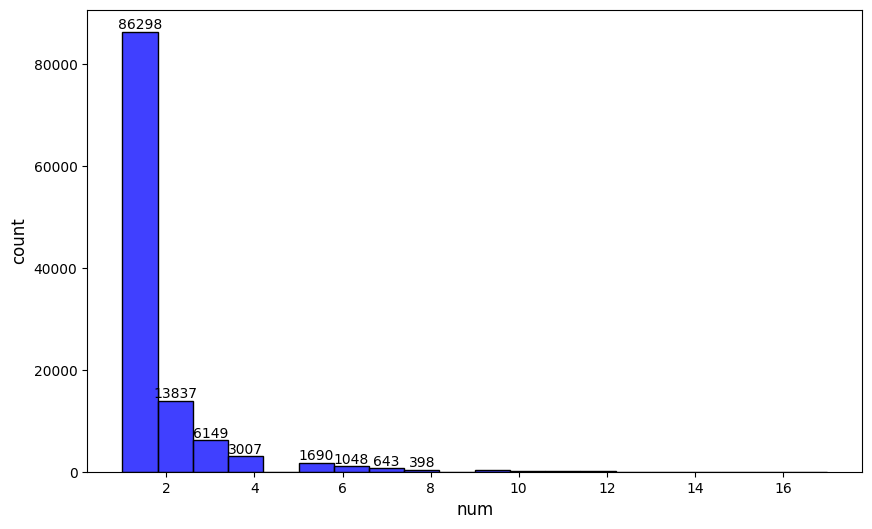

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 你的数值列表
data = num_p

# 创建直方图
plt.figure(figsize=(10, 6))
ax = sns.histplot(num_p, bins=20, color='blue', edgecolor='black')

# 获取 bin 的边界
bins = np.histogram_bin_edges(num_p, bins=10)

# 在每个 bin 顶部添加计数值，并在 x 轴标注 bin 范围
for patch, left_edge, right_edge in zip(ax.patches, bins[:-1], bins[1:]):
    height = patch.get_height()  # 获取柱子的高度（频数）
    if height > 0:  # 只标注非零的 bin
        ax.text(patch.get_x() + patch.get_width() / 2, height, f'{int(height)}', 
                ha='center', va='bottom', fontsize=10, color='black')

# 添加标题和标签
plt.xlabel("num", fontsize=12)
plt.ylabel("count", fontsize=12)

# 显示图表
plt.show()

## 测试效果

In [ ]:
avg_probabilities_numpy = loaded_data["avg_probabilities"]
filtered_tokens_list = loaded_data["filtered_tokens"]

print(avg_probabilities_numpy)
print(filtered_tokens_list)

In [21]:
s = "What is the distance, in units, between the points $(2, -6)$ and $(-4, 3)$? Express your answer in simplest radical form. Please reason step by step, and put your final answer within \\boxed{{}}. Alright, so I have this problem here where I need to find the distance between two points on a coordinate plane. The points are (2, -6) and (-4, 3). Hmm, okay, let me think about how to approach this. I remember something about the distance formula from my geometry class. I think it involves the coordinates of the two points. \n\nFirst, let me recall the distance formula. If I have two points, say (x1, y1) and (x2, y2), the distance between them is calculated using the square root of [(x2 - x1) squared plus (y2 - y1) squared]. So, it's like taking the differences in the x-coordinates and y-coordinates, squaring them, adding them together, and then taking the square root of that sum. That should give me the straight-line distance between the two points. \n\nAlright, so applying that to the points given here: (2, -6) and (-4, 3). Let me label the points to make it clearer. Let\u2019s say (x1, y1) is (2, -6) and (x2, y2) is (-4, 3). \n\nNow, I need to find the differences in the x and y coordinates. So, starting with the x-coordinates: x2 - x1 is -4 - 2. Wait, is that right? Hold on, x2 is -4 and x1 is 2. So, subtracting x1 from x2 would be -4 - 2, which is -6. Hmm, but actually, in the distance formula, it doesn't matter if it's positive or negative because when we square it, the negative will become positive. So, maybe I should just compute the absolute difference to make it easier. \n\nBut wait, let me double-check. The formula is (x2 - x1)^2, so if x2 is less than x1, the result will be negative, but when squared, it becomes positive. So, whether I do -4 - 2 or 2 - (-4), the squared term will be the same. Let me compute both ways to be sure.\n\nFirst, x2 - x1: -4 - 2 = -6. Then, y2 - y1: 3 - (-6) = 3 + 6 = 9. So, squaring these, (-6)^2 is 36, and 9^2 is 81. Then, adding them together: 36 + 81 = 117. So, the distance is the square root of 117.\n\nBut wait, 117 doesn't look like a perfect square. Let me see if it can be simplified. Breaking down 117: 117 divided by 9 is 13, because 9 times 13 is 117. So, 117 is 9 times 13. Therefore, sqrt(117) can be written as sqrt(9*13), which is sqrt(9)*sqrt(13), and since sqrt(9) is 3, that becomes 3*sqrt(13). \n\nSo, putting it all together, the distance between the two points is 3 times the square root of 13 units. Let me just recap to make sure I didn't make any mistakes. I took the coordinates, subtracted them, squared each difference, added them, and then took the square root. That seems correct.\n\nJust to double-check, I can visualize the points on the coordinate plane. The first point is at (2, -6), which is in the fourth quadrant, and the second point is at (-4, 3), which is in the second quadrant. The distance between them should be a straight line across the plane, not along the x or y-axis. So, the calculation seems reasonable because it's not a horizontal or vertical line; it's diagonal, which would result in a distance that's a combination of horizontal and vertical distances.\n\nAlternatively, I can think of the horizontal distance between them as the difference in the x-coordinates, which is 2 - (-4) = 6 units. The vertical distance is the difference in the y-coordinates, which is 3 - (-6) = 9 units. So, the horizontal distance is 6, the vertical distance is 9. Then, the distance between the points would be the hypotenuse of a right-angled triangle with legs of 6 and 9. \n\nUsing the Pythagorean theorem, which states that in a right-angled triangle, the square of the hypotenuse is equal to the sum of the squares of the other two sides. So, hypotenuse squared is 6^2 + 9^2 = 36 + 81 = 117. Therefore, the hypotenuse is sqrt(117), which simplifies to 3*sqrt(13). \n\nOkay, so both methods give me the same result. That makes me feel confident that 3*sqrt(13) is the correct distance. Just to make sure, I can also compute sqrt(117) using a calculator. Let me do that. \n\nCalculating sqrt(117): 117 is between 100 and 121, so sqrt(117) should be between 10 and 11. Let me see: 10.8 squared is 116.64, which is just under 117. So, sqrt(117) is approximately 10.8167. Then, 3*sqrt(13) would be approximately 3*3.6055512755, which is approximately 10.8166538265. So, that matches up with the decimal approximation of sqrt(117). \n\nTherefore, both the exact value and the approximate decimal value check out. So, I think I can safely conclude that the distance between the points (2, -6) and (-4, 3) is 3*sqrt(13) units.\n\n**Final Answer**\nThe distance between the points is \\boxed{3\\sqrt{13}} units.\n</think>\n\nTo find the distance between the points \\((2, -6)\\) and \\((-4, 3)\\), we use the distance formula. The distance formula is given by:\n\n\\[\n\\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}\n\\]\n\nLabeling the points as \\((x_1, y_1) = (2, -6)\\) and \\((x_2, y_2) = (-4, 3)\\), we calculate the differences in the coordinates:\n\n\\[\nx_2 - x_1 = -4 - 2 = -6\n\\]\n\\[\ny_2 - y_1 = 3 - (-6) = 3 + 6 = 9\n\\]\n\nNext, we square these differences:\n\n\\[\n(-6)^2 = 36\n\\]\n\\[\n9^2 = 81\n\\]\n\nAdding these squared differences:\n\n\\[\n36 + 81 = 117\n\\]\n\nTaking the square root of the sum:\n\n\\[\n\\sqrt{117}\n\\]\n\nWe simplify \\(\\sqrt{117}\\) by noting that 117 factors into \\(9 \\times 13\\):\n\n\\[\n\\sqrt{117} = \\sqrt{9 \\times 13} = \\sqrt{9} \\times \\sqrt{13} = 3\\sqrt{13}\n\\]\n\nThus, the distance between the points is \\(\\boxed{3\\sqrt{13}}\\) units."

In [8]:
s ="Please reason step by step, and put your final answer within \\boxed{{}}. Let's solve the problem step by step. We need to find the value of \\(a_9\\) given that \\(a_{i+1} = \\frac{1}{1 - a_i}\\) and \\(a_3 = a_1\\).\n\nFirst, let's denote \\(a_1 = x\\). Then, we can find the values of \\(a_2\\), \\(a_3\\), and so on in terms of \\(x\\):\n\n1. \\(a_2 = \\frac{1}{1 - a_1} = \\frac{1}{1 - x}\\)\n2. \\(a_3 = \\frac{1}{1 - a_2} = \\frac{1}{1 - \\frac{1}{1 - x}} = \\frac{1}{\\frac{(1 - x) - 1}{1 - x}} = \\frac{1}{\\frac{-x}{1 - x}} = \\frac{1 - x}{-x} = \\frac{x - 1}{x}\\)\n3. \\(a_4 = \\frac{1}{1 - a_3} = \\frac{1}{1 - \\frac{x - 1}{x}} = \\frac{1}{\\frac{x - (x - 1)}{x}} = \\frac{1}{\\frac{1}{x}} = x\\)\n\nWe see that \\(a_4 = a_1\\). This means the sequence is periodic with a period of 3. Therefore, \\(a_3 = a_1\\), \\(a_4 = a_1\\), \\(a_5 = a_2\\), \\(a_6 = a_3 = a_1\\), and so on. So, \\(a_9 = a_3 = a_1 = x\\).\n\nNow, we need to find \\((a_9)^9\\). Since \\(a_9 = x\\), we have \\((a_9)^9 = x^9\\).\n\nTo find \\(x\\), we use the fact that \\(a_3 = a_1\\):\n\n\\[a_3 = \\frac{x - 1}{x} = x\\]\n\nSolving for \\(x\\):\n\n\\[\\frac{x - 1}{x} = x\\]\n\\[x - 1 = x^2\\]\n\\[x^2 - x + 1 = 0\\]\n\nThis quadratic equation has no real solutions, but we can still find \\(x^9\\) by noting that the sequence is periodic with period 3. Since \\(a_9 = a_3 = a_1 = x\\), we need to find the value of \\(x^9\\).\n\nSince \\(a_3 = a_1\\), we have:\n\n\\[a_3 = \\frac{x - 1}{x} = x\\]\n\\[x^2 - x + 1 = 0\\]\n\nWe can use the fact that \\(x^3 = 1\\) (from the periodicity of the sequence) to find \\(x^9\\):\n\n\\[x^9 = (x^3)^3 = 1^3 = 1\\]\n\nTherefore, the final answer is \\(\\boxed{1}\\)."

In [22]:
s_p = s.split('\n\n')

In [23]:
for s_i in s_p:
    print(s_i)

What is the distance, in units, between the points $(2, -6)$ and $(-4, 3)$? Express your answer in simplest radical form. Please reason step by step, and put your final answer within \boxed{{}}. Alright, so I have this problem here where I need to find the distance between two points on a coordinate plane. The points are (2, -6) and (-4, 3). Hmm, okay, let me think about how to approach this. I remember something about the distance formula from my geometry class. I think it involves the coordinates of the two points. 
First, let me recall the distance formula. If I have two points, say (x1, y1) and (x2, y2), the distance between them is calculated using the square root of [(x2 - x1) squared plus (y2 - y1) squared]. So, it's like taking the differences in the x-coordinates and y-coordinates, squaring them, adding them together, and then taking the square root of that sum. That should give me the straight-line distance between the two points. 
Alright, so applying that to the points give

In [2]:
import torch
import __init__
from transformers import AutoModelForCausalLM, AutoTokenizer, Qwen2ForCausalLM
target_model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B'
target_model = AutoModelForCausalLM.from_pretrained(
    target_model_name, torch_dtype=torch.float16,device_map="auto", low_cpu_mem_usage=True, attn_implementation="flash_attention_2",
)
tokenizer = AutoTokenizer.from_pretrained(target_model_name)

/home/wxy320/miniconda3/envs/multio1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 8/8 [09:03<00:00, 67.93s/it]


In [38]:
question = "What is the distance, in units, between the points $(2, -6)$ and $(-4, 3)$? Express your answer in simplest radical form. Please reason step by step, and put your final answer within \\boxed{{}}. Alright, so I have this problem here where I need to find the distance between two points on a coordinate plane. The points are (2, -6) and (-4, 3). Hmm, okay, let me think about how to approach this. I remember something about the distance formula from my geometry class. I think it involves the coordinates of the two points. \n\nFirst, let me recall the distance formula. If I have two points, say (x1, y1) and (x2, y2), the distance between them is calculated using the square root of [(x2 - x1) squared plus (y2 - y1) squared]. So, it's like taking the differences in the x-coordinates and y-coordinates, squaring them, adding them together, and then taking the square root of that sum. That should give me the straight-line distance between the two points. \n\nAlright, so applying that to the points given here: (2, -6) and (-4, 3). Let me label the points to make it clearer. Let\u2019s say (x1, y1) is (2, -6) and (x2, y2) is (-4, 3). \n\nNow, I need to find the differences in the x and y coordinates. So, starting with the x-coordinates: x2 - x1 is -4 - 2. Wait, is that right? Hold on, x2 is -4 and x1 is 2. So, subtracting x1 from x2 would be -4 - 2, which is -6. Hmm, but actually, in the distance formula, it doesn't matter if it's positive or negative because when we square it, the negative will become positive. So, maybe I should just compute the absolute difference to make it easier. \n\nBut wait, let me double-check. The formula is (x2 - x1)^2, so if x2 is less than x1, the result will be negative, but when squared, it becomes positive. So, whether I do -4 - 2 or 2 - (-4), the squared term will be the same. Let me compute both ways to be sure.\n\nFirst, x2 - x1: -4 - 2 = -6. Then, y2 - y1: 3 - (-6) = 3 + 6 = 9. So, squaring these, (-6)^2 is 36, and 9^2 is 81. Then, adding them together: 36 + 81 = 117. So, the distance is the square root of 117.\n\nBut wait, 117 doesn't look like a perfect square. Let me see if it can be simplified. Breaking down 117: 117 divided by 9 is 13, because 9 times 13 is 117. So, 117 is 9 times 13. Therefore, sqrt(117) can be written as sqrt(9*13), which is sqrt(9)*sqrt(13), and since sqrt(9) is 3, that becomes 3*sqrt(13). \n\nSo, putting it all together, the distance between the two points is 3 times the square root of 13 units. Let me just recap to make sure I didn't make any mistakes. I took the coordinates, subtracted them, squared each difference, added them, and then took the square root. That seems correct.\n\nJust to double-check, I can visualize the points on the coordinate plane. The first point is at (2, -6), which is in the fourth quadrant, and the second point is at (-4, 3), which is in the second quadrant. The distance between them should be a straight line across the plane, not along the x or y-axis. So, the calculation seems reasonable because it's not a horizontal or vertical line; it's diagonal, which would result in a distance that's a combination of horizontal and vertical distances.\n\nAlternatively, I can think of the horizontal distance between them as the difference in the x-coordinates, which is 2 - (-4) = 6 units. The vertical distance is the difference in the y-coordinates, which is 3 - (-6) = 9 units. So, the horizontal distance is 6, the vertical distance is 9. Then, the distance between the points would be the hypotenuse of a right-angled triangle with legs of 6 and 9. \n\nUsing the Pythagorean theorem, which states that in a right-angled triangle, the square of the hypotenuse is equal to the sum of the squares of the other two sides. So, hypotenuse squared is 6^2 + 9^2 = 36 + 81 = 117. Therefore, the hypotenuse is sqrt(117), which simplifies to 3*sqrt(13). \n\nOkay, so both methods give me the same result. That makes me feel confident that 3*sqrt(13) is the correct distance. Just to make sure, I can also compute sqrt(117) using a calculator. Let me do that. \n\nCalculating sqrt(117): 117 is between 100 and 121, so sqrt(117) should be between 10 and 11. Let me see: 10.8 squared is 116.64, which is just under 117. So, sqrt(117) is approximately 10.8167. Then, 3*sqrt(13) would be approximately 3*3.6055512755, which is approximately 10.8166538265. So, that matches up with the decimal approximation of sqrt(117). \n\nTherefore, both the exact value and the approximate decimal value check out. So, I think I can safely conclude that the distance between the points (2, -6) and (-4, 3) is 3*sqrt(13) units.\n\n**Final Answer**\nThe distance between the points is \\boxed{3\\sqrt{13}} units.\n</think>\n\nTo find the distance between the points \\((2, -6)\\) and \\((-4, 3)\\), we use the distance formula. The distance formula is given by:\n\n\\[\n\\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}\n\\]\n\nLabeling the points as \\((x_1, y_1) = (2, -6)\\) and \\((x_2, y_2) = (-4, 3)\\), we calculate the differences in the coordinates:\n\n\\[\nx_2 - x_1 = -4 - 2 = -6\n\\]\n\\[\ny_2 - y_1 = 3 - (-6) = 3 + 6 = 9\n\\]\n\nNext, we square these differences:\n\n\\[\n(-6)^2 = 36\n\\]\n\\[\n9^2 = 81\n\\]\n\nAdding these squared differences:\n\n\\[\n36 + 81 = 117\n\\]\n\nTaking the square root of the sum:\n\n\\[\n\\sqrt{117}\n\\]\n\nWe simplify \\(\\sqrt{117}\\) by noting that 117 factors into \\(9 \\times 13\\):\n\n\\[\n\\sqrt{117} = \\sqrt{9 \\times 13} = \\sqrt{9} \\times \\sqrt{13} = 3\\sqrt{13}\n\\]\n\nThus, the distance between the points is \\(\\boxed{3\\sqrt{13}}\\) units."
print(len(question))

5468


In [37]:
print(len(question+response_text))

2326


In [94]:
from utils.data_utils import read_saved_results
datas = read_saved_results('/home/wxy320/ondemand/program/speculative_thinking/results/MATH500_Qwen-math-1.5b_None_0.01.json')

In [96]:

i = 18
question ="Please reason step by step, and put your final answer within \\boxed{{}}. " +datas[i]['question']+"<think>\n"+datas[i]['generated_answer']
s_p = question.split('.')
s_p

['Please reason step by step, and put your final answer within \\boxed{{}}',
 ' $\\overline{BC}$ is parallel to the segment through $A$, and $AB = BC$',
 ' What is the number of degrees represented by $x$?\n\n[asy]\ndraw((0,0)--(10,0));\ndraw((0,3)--(10,3));\ndraw((2,3)--(8,0));\ndraw((2,3)--(4,0));\nlabel("$A$",(2,3),N);\nlabel("$B$",(4,0),S);\nlabel("$C$",(8,0),S);\nlabel("$124^{\\circ}$",(2,3),SW);\nlabel("$x^{\\circ}$",(4',
 '5,3),S);\n[/asy]<think>\nPlease reason step by step, and put your final answer within \\boxed{{}}',
 ' $\\overline{BC}$ is parallel to the segment through $A$, and $AB = BC$',
 ' What is the number of degrees represented by $x$?\n\n[asy]\ndraw((0,0)--(10,0));\ndraw((0,3)--(10,3));\ndraw((2,3)--(8,0));\ndraw((2,3)--(4,0));\nlabel("$A$",(2,3),N);\nlabel("$B$",(4,0),S);\nlabel("$C$",(8,0),S);\nlabel("$124^{\\circ}$",(2,3),SW);\nlabel("$x^{\\circ}$",(4',
 "5,3),S);\n[/asy]\nLet's solve the problem step-by-step",
 '\n\n1',
 ' **Understand the Geometry:**\n   - We h

In [97]:
from explore_diff2 import decoding_chat

question = ''
for i in range(len(s_p)):
    s_i = s_p[i]
    question = question + s_i+'.\n\n\n\n'
    # response_text, corrected_tokens, num_tokens, record_tokens, avg_probabilities = decoding_chat(
    #     target_model, tokenizer, question, '', 
    #     temperature=0.6, topk=0, topp=0.95, max_tokens=15
    # )
    # print('question:', question[-40:]+s_p[i+1][:40])
    # print('response_text:', response_text)
    # print([r['token'] for r in record_tokens])
    # print('__________________')
    # Tokenize input
    input_ids = tokenizer.encode(question, return_tensors='pt').to(target_model.device)

    # Generate response
    output_ids = target_model.generate(
        input_ids,
        temperature=0.6,
        top_k=0,
        top_p=0.95,
        max_length=input_ids.shape[1] + 15,
        do_sample=True
    )

    # Decode response
    response_text = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True)

    print('question:', question[-40:] + (s_p[i+1][:40] if i + 1 < len(s_p) else ''))
    print('response_text:', response_text)
    print('__________________')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: your final answer within \boxed{{}}.



 $\overline{BC}$ is parallel to the segm
response_text: Okay, so I've got this problem here: I need to find the
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question:  segment through $A$, and $AB = BC$.



 What is the number of degrees represent
response_text: Okay, so I have this geometry problem here. Let me try to visualize
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: ",(2,3),SW);
label("$x^{\circ}$",(4.



5,3),S);
[/asy]<think>
Please reason ste
response_text: Alright, so I've got this geometry problem here. Let me see if
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: your final answer within \boxed{{}}.



 $\overline{BC}$ is parallel to the segm
response_text:  $\overline{BC}$ is parallel to the segment through $A$,
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question:  segment through $A$, and $AB = BC$.



 What is the number of degrees represent
response_text:  What is the number of degrees represented by $x$?

[asy]

__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: ",(2,3),SW);
label("$x^{\circ}$",(4.



5,3),S);
[/asy]
Let's solve the problem 
response_text: 5,3),S);
[/asy]

Okay, so I need to
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: et's solve the problem step-by-step.





1
response_text: First, let's try to understand the given information and the diagram.

We
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: ve the problem step-by-step.





1.



 **Understand the Geometry:**
   - We ha
response_text: First, let's understand the given information:

- Points A, B,
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: a triangle \(ABC\) with \(AB = BC\).




   - The angle at \(A\) is \(124^\circ\
response_text:    - Segment \(\overline{BC}\) is parallel to the
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: The angle at \(A\) is \(124^\circ\).




   - Since \(AB = BC\), triangle \(ABC\
response_text:    - Segment \(BC\) is parallel to a segment through \(A\
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: ith \(\angle BAC = \angle BCA = x\).




   - The sum of the angles in a triangl
response_text: Wait, no. If \(AB = BC\), then the angles opposite
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: gles in a triangle is \(180^\circ\).





2
response_text: 2.



 **Set Up the Equation:**
   - \(124
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: a triangle is \(180^\circ\).





2.



 **Calculate the Angles:**
   - The angl
response_text:  **Set Up the Equation:**
   - In triangle \(ABC\),

__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: n triangle \(ABC\) is \(180^\circ\).




   - Since \(\angle BAC = x\) and \(\an
response_text:    - So, \(x + x + 124^\circ
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question:  the value of \(x\) is \(28^\circ\).





Let's confirm this with Python and sym
response_text: **Final Answer**
The number of degrees represented by \(x\) is \
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: as sp

# Define the variable
x = sp.



symbols('x')

# Equation based on the su
response_text: Symbol('x')

# Set up the equation based on the sum of angles
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: ngles in the triangle
equation = sp.



Eq(2*x + 124, 180)

# Solve the equation
response_text: Eq(2*x + 124, 180)


__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: 
# Solve the equation
solution = sp.



solve(equation, x)[0]

# Print the solut
response_text: solve(equation, x)

print(solution)
```

The code will
__________________


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


question: he value of \(x\) is \(\boxed{28}\).




response_text: **Final Answer**
The number of degrees represented by \(x\) is \
__________________
question: lue of \(x\) is \(\boxed{28}\).



.




response_text: **Final Answer**
The number of degrees represented by \(x\) is \
__________________


In [48]:
from explore_diff2 import decoding_chat

question = "What is the smallest positive perfect cube that can be written as the sum of three consecutive integers? Please reason step by step, and put your final answer within \\boxed{{}}. Okay, so I need to find the smallest positive perfect cube that can be written as the sum of three consecutive integers. Hmm, let's break this down step by step. \n\nFirst, let's clarify what is meant by consecutive integers. Consecutive integers are numbers that follow each other in order without any gaps. So, if I denote the first integer as n, then the next two consecutive integers would be n+1 and n+2. Therefore, the sum of these three integers would be n + (n+1) + (n+2).\n\nLet me write that down:\n\nSum = n + (n + 1) + (n + 2)\n\nSimplifying this expression:\n\nSum = n + n + 1 + n + 2\nSum = 3n + 3\n\nSo, the sum simplifies to 3n + 3. Hmm, that's 3(n + 1). Interesting. So, the sum is three times (n + 1). \n\nNow, the problem states that this sum must be a perfect cube. A perfect cube is a number that can be expressed as some integer raised to the power of three. So, we're looking for a perfect cube, let's call it C, such that C = 3(n + 1). \n\nSince C is a perfect cube, it can be written as k\\u00b3 where k is a positive integer. So, we have:\n\nk\\u00b3 = 3(n + 1)\n\nWhich means that 3 divides k\\u00b3. Since 3 is a prime number, if 3 divides k\\u00b3, then 3 must divide k. So, let me write that down: k = 3m where m is an integer. \n\nSubstituting back into the equation:\n\n(3m)\\u00b3 = 3(n + 1)\n27m\\u00b3 = 3(n + 1)\n\nDivide both sides by 3:\n\n9m\\u00b3 = n + 1\n\nSo, n + 1 = 9m\\u00b3, which implies that n = 9m\\u00b3 - 1.\n\nTherefore, the three consecutive integers are:\n\nFirst integer: n = 9m\\u00b3 - 1\nSecond integer: n + 1 = 9m\\u00b3\nThird integer: n + 2 = 9m\\u00b3 + 1\n\nLet me check with m = 1:\n\nn = 9(1)\\u00b3 - 1 = 9 - 1 = 8\nSo, the three consecutive integers are 8, 9, 10.\n\n" #Sum: 8 + 9 + 10 = 27\n\n27 is indeed a perfect cube (3\\u00b3). So, that seems to work. "
response_text, corrected_tokens, num_tokens, record_tokens, avg_probabilities = decoding_chat(
    target_model, tokenizer, question, '', 
    temperature=0.7, topk=0, topp=0.95, max_tokens=10
)
print(question)
print('__________________')
print(question+response_text)
print(record_tokens)
print('__________________')

What is the smallest positive perfect cube that can be written as the sum of three consecutive integers? Please reason step by step, and put your final answer within \boxed{{}}. Okay, so I need to find the smallest positive perfect cube that can be written as the sum of three consecutive integers. Hmm, let's break this down step by step. 

First, let's clarify what is meant by consecutive integers. Consecutive integers are numbers that follow each other in order without any gaps. So, if I denote the first integer as n, then the next two consecutive integers would be n+1 and n+2. Therefore, the sum of these three integers would be n + (n+1) + (n+2).

Let me write that down:

Sum = n + (n + 1) + (n + 2)

Simplifying this expression:

Sum = n + n + 1 + n + 2
Sum = 3n + 3

So, the sum simplifies to 3n + 3. Hmm, that's 3(n + 1). Interesting. So, the sum is three times (n + 1). 

Now, the problem states that this sum must be a perfect cube. A perfect cube is a number that can be expressed as